# Variogram analysis and kriging for data in 1D with non-stationarity

The goal is to interpolate a non-stationary data set in 1D (based on simple or ordinary kriging) in a domain (grid), where non-stationarity are given as
- local factor (multiplier) for the ranges along the main axes of the covariance model,
- local factor (multiplier) for the total weight (variance, sill) of the covariance model.

One or several of these non-stationary features can be considered.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.3


### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## I. Build non-stationary features on a grid
Here are built the following non-stationary features on a grid:
- `r_factor_loc`: local factor (multiplier) for the range of the covariance model,
- `w_factor_loc`: local factor (multiplier) for the total weight (variance, sill) of the covariance model.

### Defining domain of simulation (grid)

In [3]:
nx = 1000 # number of cells
sx = 0.5  # cell unit
ox = 0.0  # origin

xmin, xmax = ox, ox+nx*sx

# # Set an image with simulation grid geometry defined above, and no variable
# im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

### Defining non-stationarities

#### Range

The factor (multiplier) for range `r_factor` locally varying in the grid is defined as `im_r_factor`: an image (with one variable on the grid).

#### Variance (sill)

The factor (multiplier) for the total weight (variance, sill) `w_factor` locally varying in the grid is defined as `im_w_factor`: an image (with one variable on the grid).

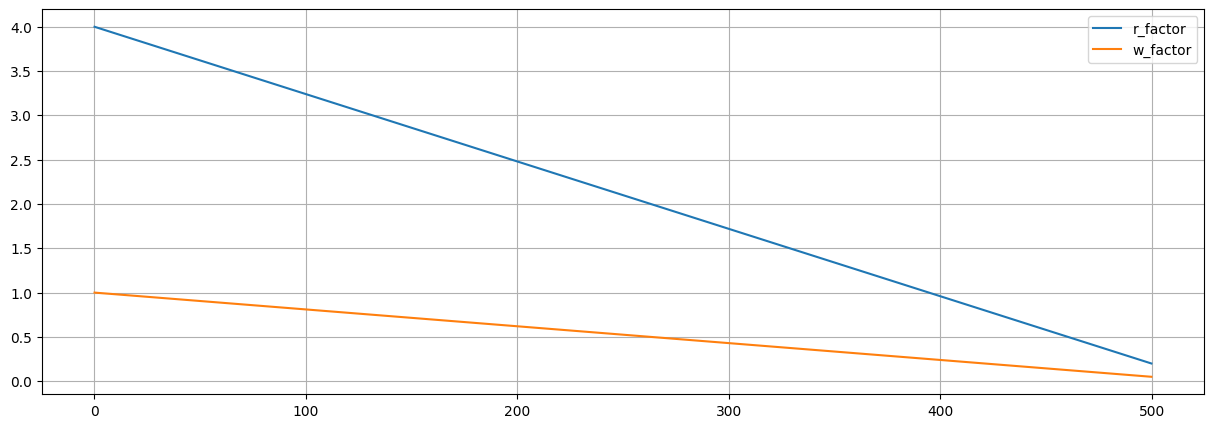

In [4]:
# Define r_factor as r0 on the left of the grid and decreasing linearly when going to the right of the grid
# ---------------
r0 = 4.0 # on the left
r1 = 0.2 # minimal value

# "Empty" image
im_r_factor = gn.img.Img(nx, 1, 1, sx, 1., 1., ox, 0., 0., nv=0)

# Add variable
r = r0 + im_r_factor.x()/im_r_factor.x().max() * (r1-r0)
im_r_factor.append_var(r)

# Define w_factor as w0 on the left of the grid and decreasing linearly when going to the right of the grid
# ---------------
w0 = 1.0 # on the left
w1 = 0.05 # minimal value

# "Empty" image
im_w_factor = gn.img.Img(nx, 1, 1, sx, 1., 1., ox, 0., 0., nv=0)

# Add variable
w = w0 + im_w_factor.xx()/im_w_factor.xx().max() * (w1-w0)
im_w_factor.append_var(w)

# Plot
# ----
plt.figure(figsize=(15,5))
plt.plot(im_r_factor.x(), im_r_factor.val[0,0,0], label='r_factor')
plt.plot(im_w_factor.x(), im_w_factor.val[0,0,0], label='w_factor')
plt.legend()
plt.grid()
plt.show()

## II Non-stationary simulations
First define a reference covariance model and generate an unconditional simulation (reference). Then build a data set by extract some points from the simulation. Then, ignoring the covariance model and starting from the data set and the maps controlling the non-stationary features:
- fit a covariance model,
- do kriging / conditional simulations

Several cases are proposed below with different non-stationary features.

## A. Non-stationary range

### Reference covariance model and non-stationarity
Define first a *stationary* reference covariance model in 1D. Then, add the desired non-stationarity feature.

In [5]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('cubic', {'w':10, 'r':50.0}), # elementary contribution
    ], name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying range: range factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.multiply_r(im_r_factor.val[0]) # range of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


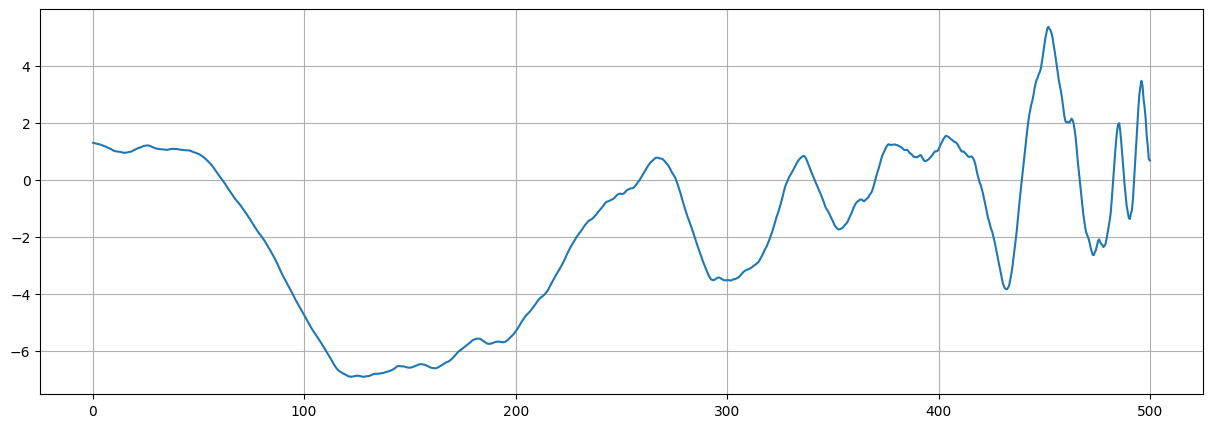

In [6]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate1D(cov_model_loc_ref, nx, sx, ox, method='simple_kriging', nneighborMax=64, nreal=nreal, nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
plt.plot(im_ref.x(), im_ref.val[0,0,0])
plt.grid()
plt.show()

### Build a non-stationary data set (1D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

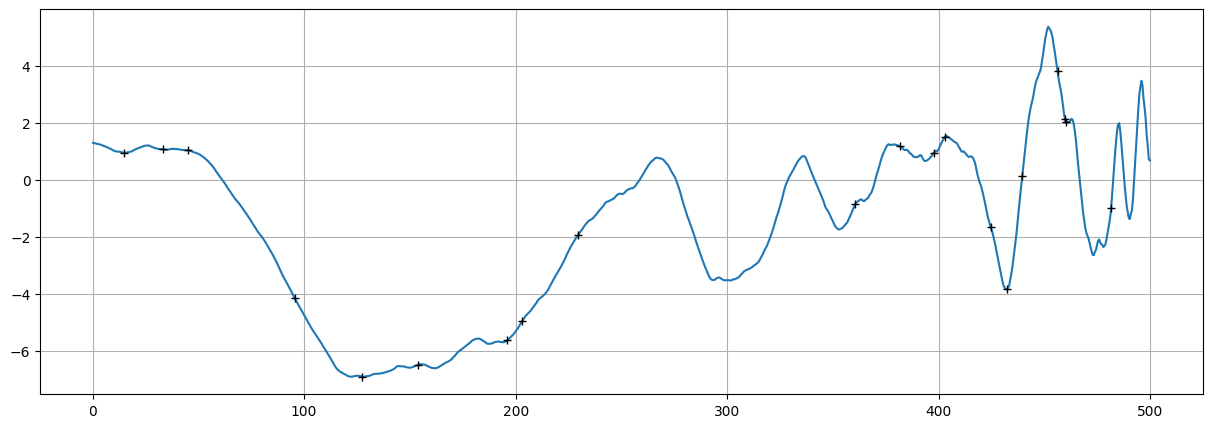

In [7]:
# Extract som points from the simulation
n = 20

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = ps.x()
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x = x + (np.random.random(n)-0.5)* im_ref.sx
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iy=0, iz=0)
np.random.seed(987)
x = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
plt.plot(im_ref.x(), im_ref.val[0,0,0])
plt.plot(x, v, '+', c='k')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 1D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (1-dimensional array of length `n`),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image.

In [8]:
# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iy=0, iz=0) 
# -> specify iy=0, iz=0: consider only x coordinates along the "line" iy=0 and iz=0

### Fitting covariance model accounting for non-stationarity

In [9]:
cov_model_to_optimize = gn.covModel.CovModel1D(elem=[
        ('cubic', {'w':np.nan, 'r':np.nan}), # elementary contribution
         ], name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, 
                coord_factor_loc_func=r_factor_inv_loc_func, # deal with non-stationarity (multiplier for range)
                bounds=([ 0,   0],  # min value for param. to fit
                        [50, 200]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.004417


*** CovModel1D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 11.056283803568842
        r = 44.1700675984435
*****

### Show experimental variogram, fitted model and reference model

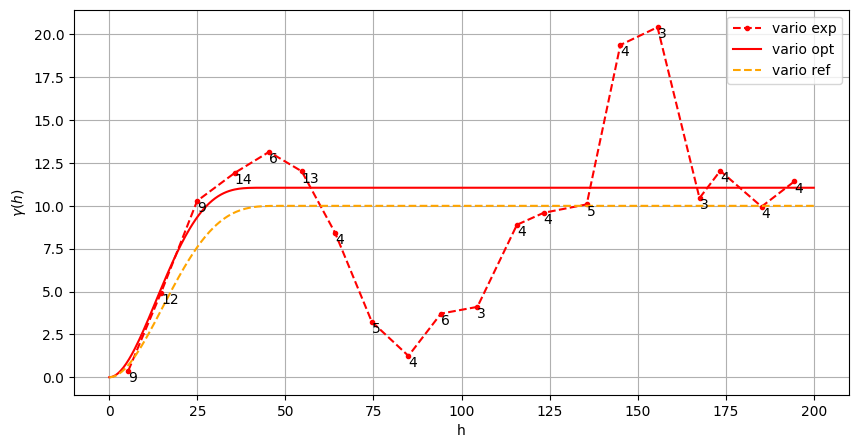

In [10]:
hmax = 200.0

hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=hmax, 
                                              coord_factor_loc_func=r_factor_inv_loc_func, 
                                              ncla=20, make_plot=False)

plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, c='red', label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=hmax, c='red', label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=hmax, c='orange', ls='dashed', label='vario ref')
plt.legend()

plt.show()

### Set non-stationarity covariance model

In [11]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.multiply_r(im_r_factor.val[0])

### Kriging and conditional simulations

In [12]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate1D(cov_model_loc_opt, nx, sx, ox, 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Kriging - elapsed time: 0.003974 sec


In [13]:
# Simulation
nreal = 1000
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate1D_mp(cov_model_loc_opt, nx, sx, ox, 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (221 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
1000 simul. - elapsed time: 2.787 sec


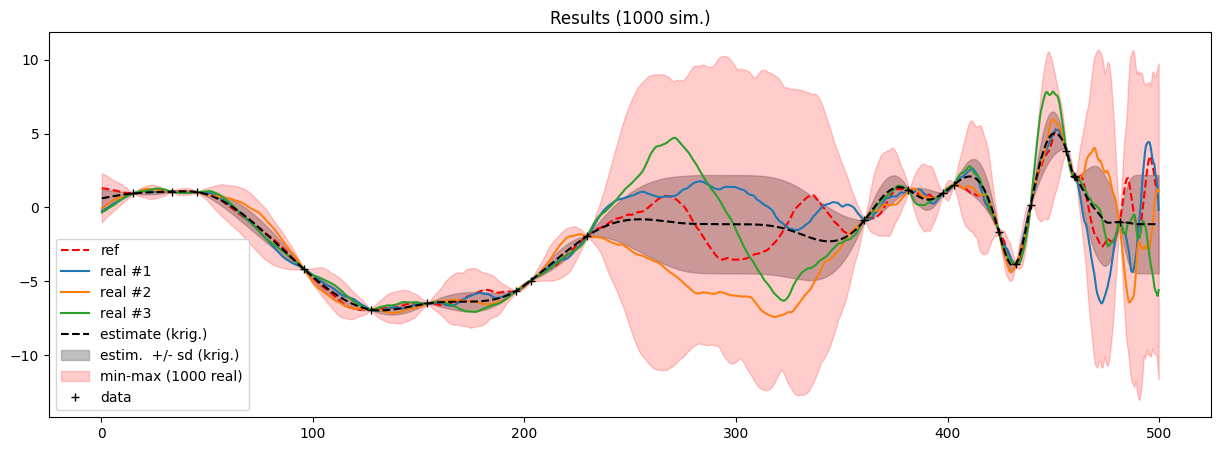

In [14]:
# Plot the first simulations and the results of estimation
plt.figure(figsize=(15,5))

plt.plot(im_ref.x(), im_ref.val[0,0,0,:], c='red', ls='dashed', label='ref')

for i in range(3):
    plt.plot(simul.x(), simul.val[i,0,0,:], label='real #{}'.format(i+1))

plt.plot(im_krig.x(), im_krig.val[0,0,0,:], c='black', ls='dashed', label='estimate (krig.)')
plt.fill_between(im_krig.x(), 
                 im_krig.val[0,0,0,:] - im_krig.val[1,0,0,:], 
                 im_krig.val[0,0,0,:] + im_krig.val[1,0,0,:], 
                 color='gray', alpha=.5, label='estim.  +/- sd (krig.)')

plt.fill_between(simul.x(), simul.val[:,0,0,:].min(axis=0), simul.val[:,0,0,:].max(axis=0), 
                 color='red', alpha=.2, label='min-max ({} real)'.format(nreal))

plt.plot(x, v, '+', c='k', label='data') # add conditioning points

plt.legend()
plt.title(f'Results ({nreal} sim.)')
plt.show()

## B. Non-stationary variance (sill)

### Reference covariance model and non-stationarity
Define first a *stationary* reference covariance model in 1D. Then, add the desired non-stationarity feature.

In [15]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('cubic', {'w':10, 'r':50.0}), # elementary contribution
    ], name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying weight (sill): weight factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.multiply_w(im_w_factor.val[0]) # weight of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


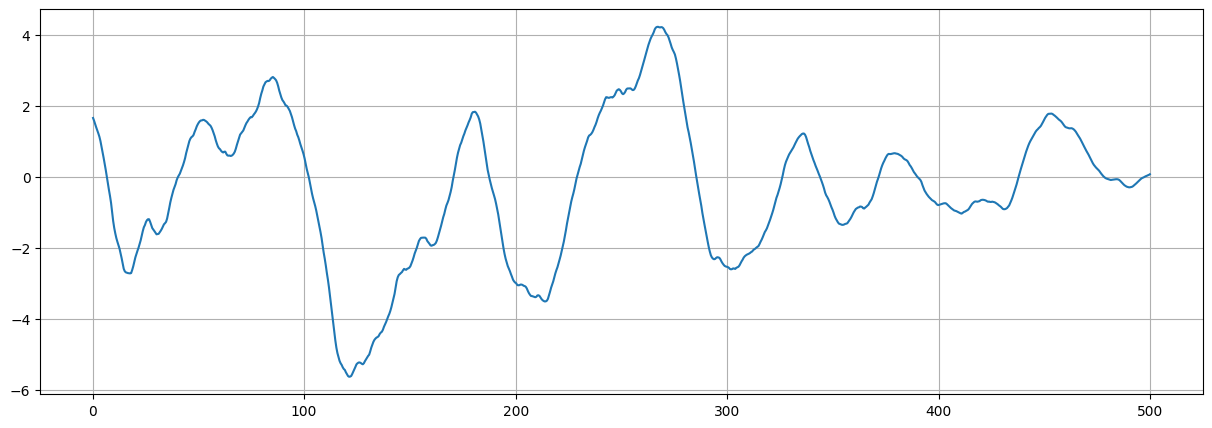

In [16]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate1D(cov_model_loc_ref, nx, sx, ox, method='simple_kriging', nneighborMax=64, nreal=nreal, nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
plt.plot(im_ref.x(), im_ref.val[0,0,0])
plt.grid()
plt.show()

### Build a non-stationary data set (1D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

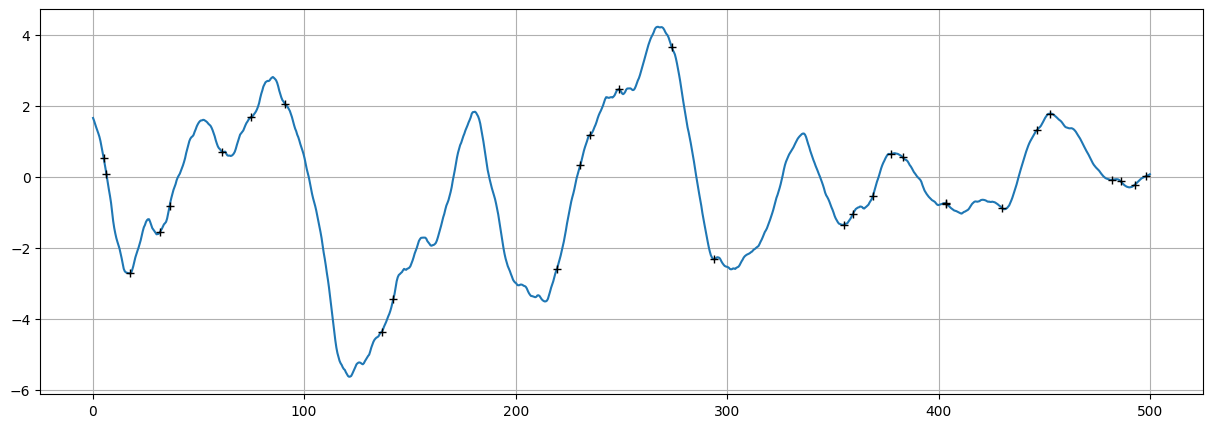

In [17]:
# Extract som points from the simulation
n = 30

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = ps.x()
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x = x + (np.random.random(n)-0.5)* im_ref.sx
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iy=0, iz=0)
np.random.seed(957)
x = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
plt.plot(im_ref.x(), im_ref.val[0,0,0])
plt.plot(x, v, '+', c='k')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 1D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (1-dimensional array of length `n`),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_w_factor`: image of the factor (multiplier) `w_factor` in the grid; the function `w_factor_inv_loc_func` (interpolator of the inverse of `w_factor` in the grid) is built from this image.

**Note:** Locally varying weight seems to affect the estimation of the range.

In [18]:
# Set a function interpolating the inverse of the w_factor (given location)
im_tmp = gn.img.copyImg(im_w_factor)
im_tmp.val = 1.0/im_tmp.val
w_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iy=0, iz=0) 
# -> specify iy=0, iz=0: consider only x coordinates along the "line" iy=0 and iz=0

### Fitting covariance model accounting for non-stationarity

In [19]:
cov_model_to_optimize = gn.covModel.CovModel1D(elem=[
        ('cubic', {'w':np.nan, 'r':np.nan}), # elementary contribution
         ], name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, 
                w_factor_loc_func=w_factor_inv_loc_func, # deal with non-stationarity (multiplier for weight)
                loc_m=10, # loc_m > 0: number of sub-intervals btw pair of points to estimate local factor (default 1)
                          # loc_m = 0: take factor from one point
                bounds=([ 0,   0],  # min value for param. to fit
                        [50, 200]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.007623


*** CovModel1D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 8.131536714101642
        r = 42.69291249286729
*****

### Show experimental variogram, fitted model and reference model

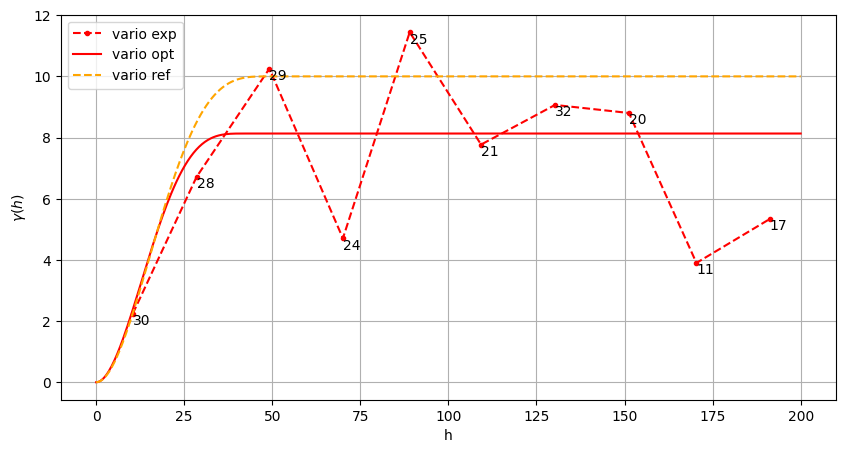

In [20]:
hmax = 200.0

hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=hmax, 
                                              w_factor_loc_func=w_factor_inv_loc_func, loc_m=10,
                                              ncla=10, make_plot=False)

plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, c='red', label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=hmax, c='red', label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=hmax, c='orange', ls='dashed', label='vario ref')
plt.legend()

plt.show()

### Set non-stationarity covariance model

In [21]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.multiply_w(im_w_factor.val[0])

### Kriging and conditional simulations

In [22]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate1D(cov_model_loc_opt, nx, sx, ox, 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Kriging - elapsed time: 0.002897 sec


In [23]:
# Simulation
nreal = 1000
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate1D_mp(cov_model_loc_opt, nx, sx, ox, 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
1000 simul. - elapsed time: 2.539 sec


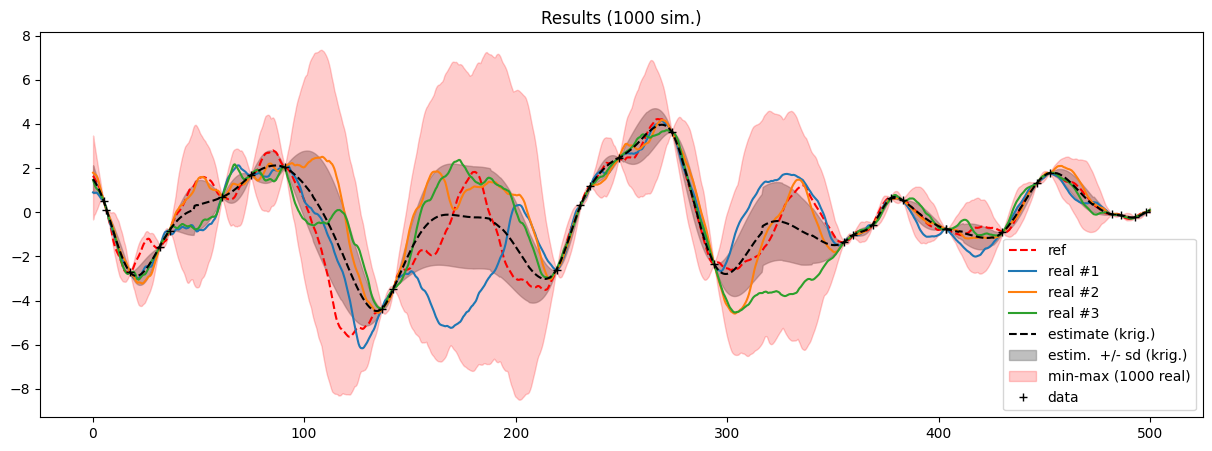

In [24]:
# Plot the first simulations and the results of estimation
plt.figure(figsize=(15,5))

plt.plot(im_ref.x(), im_ref.val[0,0,0,:], c='red', ls='dashed', label='ref')

for i in range(3):
    plt.plot(simul.x(), simul.val[i,0,0,:], label='real #{}'.format(i+1))

plt.plot(im_krig.x(), im_krig.val[0,0,0,:], c='black', ls='dashed', label='estimate (krig.)')
plt.fill_between(im_krig.x(), 
                 im_krig.val[0,0,0,:] - im_krig.val[1,0,0,:], 
                 im_krig.val[0,0,0,:] + im_krig.val[1,0,0,:], 
                 color='gray', alpha=.5, label='estim.  +/- sd (krig.)')

plt.fill_between(simul.x(), simul.val[:,0,0,:].min(axis=0), simul.val[:,0,0,:].max(axis=0), 
                 color='red', alpha=.2, label='min-max ({} real)'.format(nreal))

plt.plot(x, v, '+', c='k', label='data') # add conditioning points

plt.legend()
plt.title(f'Results ({nreal} sim.)')
plt.show()

## C. Non-stationary for range and variance (sill)

### Reference covariance model and non-stationarity
Define first a *stationary* reference covariance model in 1D. Then, add the desired non-stationarity feature.

In [25]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('cubic', {'w':10, 'r':50.0}), # elementary contribution
    ], name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying weight (sill): weight factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.multiply_w(im_w_factor.val[0]) # weight of every contribution will be multiplied
#   - Set locally varying range: range factor in the grid
cov_model_loc_ref.multiply_r(im_r_factor.val[0]) # range of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


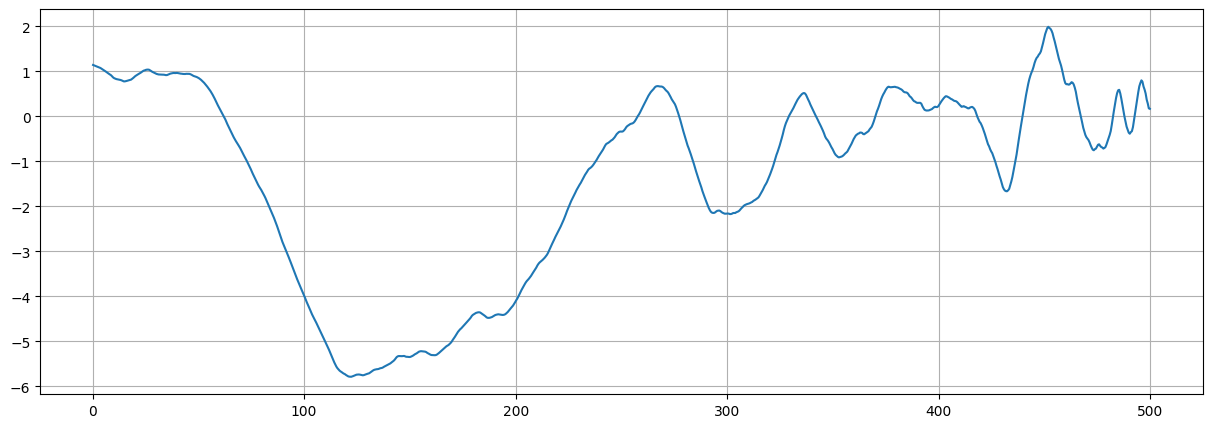

In [26]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate1D(cov_model_loc_ref, nx, sx, ox, method='simple_kriging', nneighborMax=64, nreal=nreal, nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
plt.plot(im_ref.x(), im_ref.val[0,0,0])
plt.grid()
plt.show()

### Build a non-stationary data set (1D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

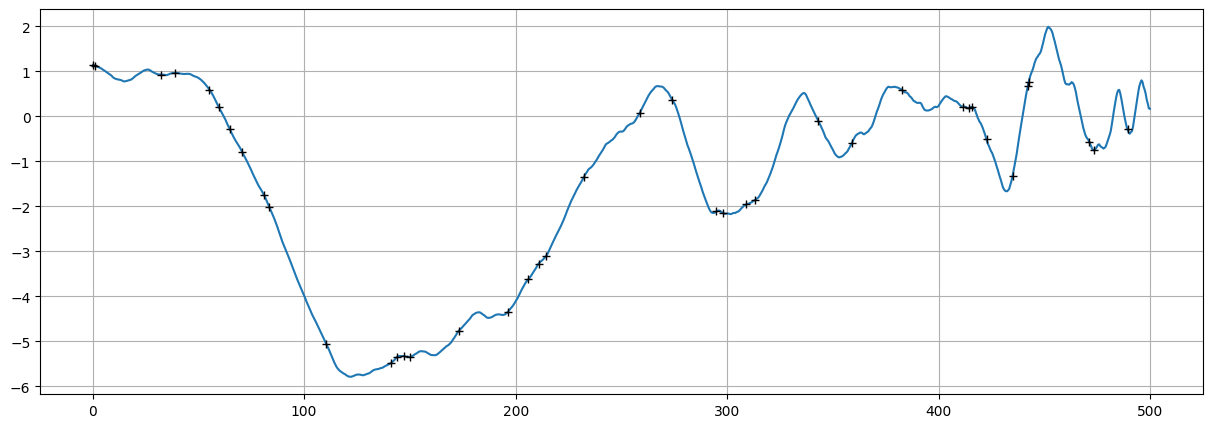

In [27]:
# Extract som points from the simulation
n = 40

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = ps.x()
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x = x + (np.random.random(n)-0.5)* im_ref.sx
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iy=0, iz=0)
np.random.seed(23)
x = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
plt.plot(im_ref.x(), im_ref.val[0,0,0])
plt.plot(x, v, '+', c='k')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 1D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (1-dimensional array of length `n`),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image,
- `im_w_factor`: image of the factor (multiplier) `w_factor` in the grid; the function `w_factor_inv_loc_func` (interpolator of the inverse of `w_factor` in the grid) is built from this image.

**Note:** Locally varying weight seems to affect the estimation of the range.

In [28]:
# Set a function interpolating the inverse of the w_factor (given location)
im_tmp = gn.img.copyImg(im_w_factor)
im_tmp.val = 1.0/im_tmp.val
w_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iy=0, iz=0) 
# -> specify iy=0, iz=0: consider only x coordinates along the "line" iy=0 and iz=0

# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iy=0, iz=0) 
# -> specify iy=0, iz=0: consider only x coordinates along the "line" iy=0 and iz=0

### Fitting covariance model accounting for non-stationarity

In [29]:
cov_model_to_optimize = gn.covModel.CovModel1D(elem=[
        ('cubic', {'w':np.nan, 'r':np.nan}), # elementary contribution
         ], name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, 
                w_factor_loc_func=w_factor_inv_loc_func, # deal with non-stationarity (multiplier for weight)
                coord_factor_loc_func=r_factor_inv_loc_func, # deal with non-stationarity (multiplier for range)
                loc_m=10, # loc_m > 0: number of sub-intervals btw pair of points to estimate local factor (default 1)
                          # loc_m = 0: take factor from one point
                bounds=([ 0,   0],  # min value for param. to fit
                        [50, 200]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.0172


*** CovModel1D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 10.426854544396779
        r = 44.40495264231914
*****

### Show experimental variogram, fitted model and reference model

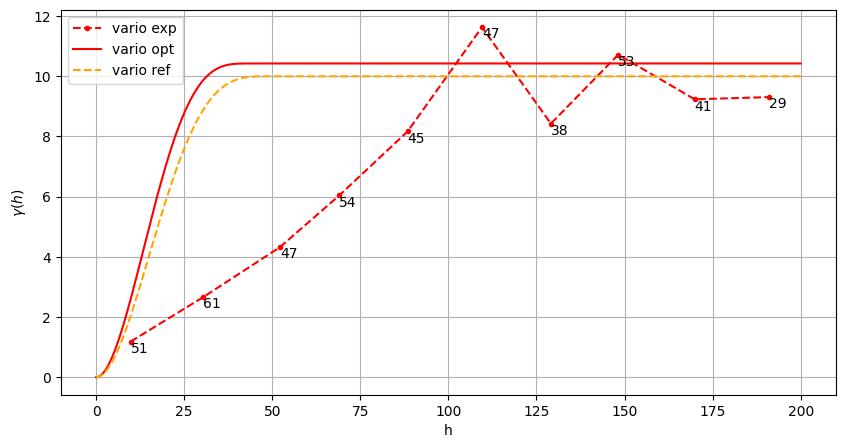

In [30]:
hmax = 200.0

hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=hmax,
                                              w_factor_loc_func=w_factor_inv_loc_func, loc_m=10,
                                              ncla=10, make_plot=False)

plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, c='red', label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=hmax, c='red', label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=hmax, c='orange', ls='dashed', label='vario ref')
plt.legend()

plt.show()

### Set non-stationarity covariance model

In [31]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.multiply_w(im_w_factor.val[0])
cov_model_loc_opt.multiply_r(im_w_factor.val[0])

### Kriging and conditional simulations

In [32]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate1D(cov_model_loc_opt, nx, sx, ox, 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (25 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Kriging - elapsed time: 0.002108 sec


In [33]:
# Simulation
nreal = 1000
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate1D_mp(cov_model_loc_opt, nx, sx, ox, 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (2959 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  3: WARNING 02015: solving kriging system fails (do as if no neighbor)
1000 simul. - elapsed time: 2.61 sec


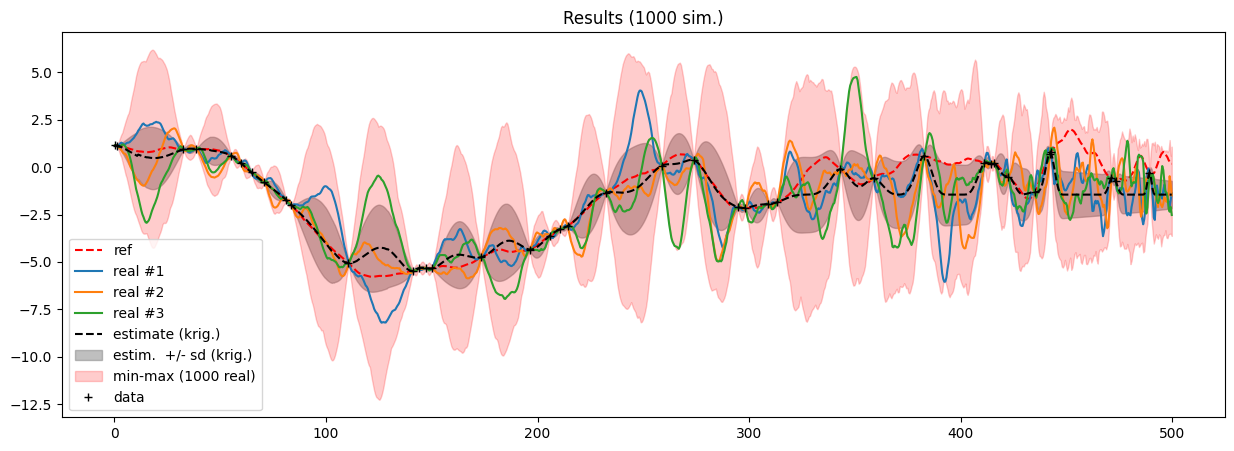

In [34]:
# Plot the first simulations and the results of estimation
plt.figure(figsize=(15,5))

plt.plot(im_ref.x(), im_ref.val[0,0,0,:], c='red', ls='dashed', label='ref')

for i in range(3):
    plt.plot(simul.x(), simul.val[i,0,0,:], label='real #{}'.format(i+1))

plt.plot(im_krig.x(), im_krig.val[0,0,0,:], c='black', ls='dashed', label='estimate (krig.)')
plt.fill_between(im_krig.x(), 
                 im_krig.val[0,0,0,:] - im_krig.val[1,0,0,:], 
                 im_krig.val[0,0,0,:] + im_krig.val[1,0,0,:], 
                 color='gray', alpha=.5, label='estim.  +/- sd (krig.)')

plt.fill_between(simul.x(), simul.val[:,0,0,:].min(axis=0), simul.val[:,0,0,:].max(axis=0), 
                 color='red', alpha=.2, label='min-max ({} real)'.format(nreal))

plt.plot(x, v, '+', c='k', label='data') # add conditioning points

plt.legend()
plt.title(f'Results ({nreal} sim.)')
plt.show()